# CIFAR 100 Dataset

To compare both types of networks we are going to use the CIFAR dataset, which contains 100 different object clases that the learnt networks should predict. Each sample of the dataset is a RGB image of size 32x32.

In [ ]:
BOOST_UP = True

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100
(_x_train, _y_train), (_x_test, _y_test) = cifar100.load_data(label_mode='fine')

169009152/169001437 [==============================] - 2s 0us/step


In [2]:
class_names = np.unique(_y_train)
num_classes = len(class_names)
# Data pre-processing
x_val = _x_train[40000:]
y_val = _y_train[40000:]
x_train = _x_train[:40000]
y_train = _y_train[:40000]
x_test = _x_test
y_test = _y_test

# Normalize the images to be values in range [0, 1]
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_val /= 255.0
x_test /= 255.0

from tensorflow.keras.utils import to_categorical
# Converts a class vector (integers) to binary class matrix
tr_labels = to_categorical(y_train, num_classes)
va_labels = to_categorical(y_val, num_classes)
te_labels = to_categorical(y_test, num_classes)

CIFAR_SIZE = (32, 32)

In [3]:
# Tensorboard
from time import time
from tensorflow.keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

# Train a convolutional Neuronal Network 

In [4]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
input_shape = (CIFAR_SIZE[0], CIFAR_SIZE[1], 3)


def base_cnn(n_filter=20, kernel_size=(3,3), strides=(1,1), drop_out=0.2, act='elu'):
    cnn = Sequential(name='f{}_k{}_s{}_do{}_{}'.format(n_filter, kernel_size[0], strides[0], drop_out, int(time())))
    cnn.add(Conv2D(n_filter, kernel_size=kernel_size, padding='same', activation=act, input_shape=input_shape))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(n_filter * 2, strides=strides, kernel_size=kernel_size, activation=act, padding='same'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(drop_out))
    cnn.add(Conv2D(n_filter * 2, strides=strides, kernel_size=kernel_size, padding='same'))
    cnn.add(Activation(act))
    cnn.add(Dropout(drop_out))
    cnn.add(Flatten())
    cnn.add(Activation(act))
    cnn.add(Dropout(drop_out))
    cnn.add(Dense(num_classes))
    cnn.add(Activation('softmax'))
    return cnn

def compile_cnn(cnn, l_rate=0.0007):
    opt = optimizers.Adam(learning_rate=l_rate)
    cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    summary = cnn.summary()
    return cnn

In [5]:
def cnn_fit(cnn, batch_size=16, epochs=40):
    data = cnn.fit(x_train, tr_labels, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(x_val, va_labels))
    temp_name = cnn.name + str(int(time()))
    cnn.save(temp_name)
    return temp_name

# Optimizing filter, kernel and stride

In [ ]:
cnns = []

for each_filter in range(20, 25, 4):
  for each_kernel_size in [(x, x) for x in range(3, 6)]:
    for each_stride in [(x, x) for x in range(1, 4)]:
      cnns.append(base_cnn(n_filter=each_filter, kernel_size=each_kernel_size, strides=each_stride))

# Optimizing adding a Dense Layer

In [ ]:
cnns = []

for each_dense in [each*each for each in range(9, 13)]:
  cnns.append(base_cnn(n_filter=20, strides=(1,1)))

TypeError: ignored

# Optimizing the Dropout rates

In [ ]:
cnns = []

for each_do in np.arange(0.2, 0.31, 0.01):
  cnns.append(base_cnn(drop_out=each_do))

In [ ]:
compiled_cnns = list(map(compile_cnn, cnns))

# Optimizing the learning rate

In [ ]:
compiled_cnns = [compile_cnn(base_cnn()) for each in np.arange(0.0005, 0.002, 0.0002)] # default = 0.001

# Optimal filter, kernel, stride, drop out, and learning rate

In [ ]:
compiled_cnns = [compile_cnn(base_cnn())]

In [ ]:
model_names = [cnn_fit(compiled_cnns[0], batch_size=each) for each in range(2, 33, 2)]

# Increase Epochs

In [ ]:
model_names = [cnn_fit(compiled_cnns[0], batch_size=30, epochs=each) for each in range(10, 150, 10)]

# Optimizing the activation function


In [ ]:
cnns = [base_cnn(), base_cnn(act='elu')]

In [ ]:
compiled_cnns = list(map(compile_cnn, cnns))

In [ ]:
model_names = [cnn_fit(each) for each in compiled_cnns]

#Combination of Optimal Hyperparameters

In [ ]:
optimal_cnn = compile_cnn(base_cnn())
history = optimal_cnn.fit(x_train, tr_labels, batch_size=16, epochs=40, verbose=0, validation_data=(x_val, va_labels))

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = optimal_cnn.evaluate(x_test, te_labels, verbose=2)

# Data Augmentation


In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [ ]:
cnn = base_cnn()
compiled_cnn=compile_cnn(cnn)
history = cnn.fit_generator(train_datagen.flow(x_train, 
                                               tr_labels, 
                                                batch_size=32), 
                            steps_per_epoch=len(x_train)//32, 
                            epochs=40,
                            validation_data=test_datagen.flow(x_val, 
                                                              va_labels, 
                                                              batch_size=16),
                            validation_steps=len(x_val)//32)  # 800//16 --> 36

Model: "f20_k3_s1_do0.2_1616864656"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 20)        560       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 40)        7240      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 40)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 40)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 40)          14440     
_________________________________________________________________
activation (Activation)      (None, 8, 8

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/40
1250/1250 [==============================] - 55s 18ms/step - loss: 4.1827 - accuracy: 0.0691 - val_loss: 3.5285 - val_accuracy: 0.1749
Epoch 2/40
 331/1250 [======>.......................] - ETA: 15s - loss: 3.6503 - accuracy: 0.1444

In [ ]:
temp_name = cnn.name + str(int(time()))
cnn.save(temp_name)
model_names = [temp_name]

INFO:tensorflow:Assets written to: f20_k3_s1_do0.2_16163543931616355210/assets


# Test Zone

Evaluate and measure the inference time:

In [ ]:
def accuracy_test(model_name):
    loaded_cnn = tf.keras.models.load_model(model_name)
    start = time()
    loss, acc = loaded_cnn.evaluate(x_test, te_labels, verbose=0)
    end = time()
    return ({'model':model_name, 'ETA':str(end - start), 'test_loss':str(loss), 'test_accuracy':str(acc)})

In [ ]:
test_result_df = pd.DataFrame(columns=['model', 'ETA', 'test_loss', 'test_accuracy'])

for each in model_names:
  test_results = accuracy_test(each)
  test_result_df = test_result_df.append(test_results, ignore_index=True)

In [ ]:
test_result_df

,model,ETA,test_loss,test_accuracy
0,f20_k3_s1_do0.2_16163543931616355210,0.844588041305542,2.439692735671997,0.39070001244544983


In [ ]:
loaded_cnn = tf.keras.models.load_model('f20_k3_s1_do0.2_16163543931616355210')
test_loss, tess_acc = loaded_cnn.evaluate(x_test, te_labels, verbose=0)

In [ ]:
type(tess_acc)

float

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


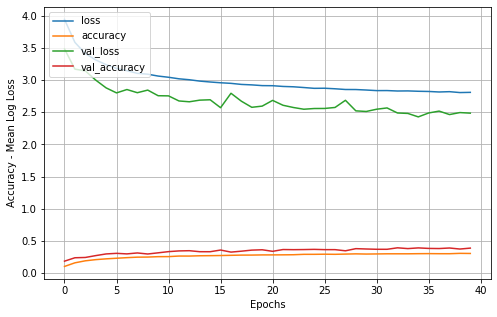

In [ ]:
print(history.history.keys())

#  "Accuracy"
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy - Mean Log Loss')
plt.xlabel('Epochs')
plt.legend(['loss', 'accuracy', 'val_loss', 'val_accuracy'], loc='upper left')
plt.grid()
plt.show()